In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans

%pylab inline

import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sch

Populating the interactive namespace from numpy and matplotlib


# The purpose of this notebook is to add as many features as we can imagine and see which ones are the most relevant

In [3]:
train = pd.read_csv('data/train_clean.csv')

## Transform attributes in numeric values

In [4]:
train.columns

Index([u'CUST_COD', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE',
       u'BIRTH_DATE', u'PAY_DEC', u'PAY_NOV', u'PAY_OCT', u'PAY_SEP',
       u'PAY_AUG', u'PAY_JUL', u'BILL_AMT_DEC', u'BILL_AMT_NOV',
       u'BILL_AMT_OCT', u'BILL_AMT_SEP', u'BILL_AMT_AUG', u'BILL_AMT_JUL',
       u'PAY_AMT_DEC', u'PAY_AMT_NOV', u'PAY_AMT_OCT', u'PAY_AMT_SEP',
       u'PAY_AMT_AUG', u'PAY_AMT_JUL', u'DEFAULT PAYMENT JAN'],
      dtype='object')

### Drop CUST_COD

We won't use it, at the moment

In [5]:
train = train.drop(['CUST_COD'], axis=1)

## Transform SEX

In [6]:
train['SEX_MISSING'] = train['SEX'].isnull()*1      # Add a column to say if sex was missing or not
train.loc[train['SEX'].isnull(), 'SEX'] = 'F' # Predict sex with majority class
train['SEX'] = train['SEX'].apply(lambda x : 0 if x == 'M' else 1)   # Convert to M -> 0, F -> 1

## Transform EDUCATION

In [7]:
train['EDUCATION_MISSING'] = train['EDUCATION'].isnull() * 1 # Add a column to say if education was missing or not
train['EDUCATION'] = train['EDUCATION'].fillna('other')    # Predict missing values as other

train = pd.get_dummies(train, columns=['EDUCATION'])   # Get one hot vector for education

## Trasform MARRIAGE

In [8]:
train['MARRIAGE_MISSING'] = train['MARRIAGE'].isnull() * 1 # Add a column to say if education was missing or not
train['MARRIAGE'] = train['MARRIAGE'].fillna('other')    # Predict missing values as other
train = pd.get_dummies(train, columns=['MARRIAGE'])   # Get one hot vector for education

## Transform BIRTH_DATE

In [9]:
train['AGE_MISSING'] = train['BIRTH_DATE'].isnull() * 1

In [10]:
import datetime

birthdates = train['BIRTH_DATE']

def get_age(date):
    try:
        return (datetime.datetime.today() - datetime.datetime.strptime(date, '%d/%m/%Y')).days//365
    except Exception as e:
        return date

birthdates = birthdates.apply(get_age)

In [11]:
birthdates.describe()

count    26182.000000
mean        36.488160
std          9.201312
min         22.000000
25%         29.000000
50%         35.000000
75%         42.000000
max         76.000000
Name: BIRTH_DATE, dtype: float64

In [12]:
# Fill NA with mean value
birthdates = birthdates.fillna(36)

In [13]:
train['AGE'] = birthdates
train = train.drop(['BIRTH_DATE'], axis=1)

## Transform all columns in float

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 33 columns):
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null int64
PAY_DEC                      26884 non-null int64
PAY_NOV                      26884 non-null int64
PAY_OCT                      26884 non-null int64
PAY_SEP                      26884 non-null int64
PAY_AUG                      26884 non-null int64
PAY_JUL                      26884 non-null int64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT_OCT                  26884 non-null float64
PAY_AMT_SEP          

In [15]:
train = train.astype('float64')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 33 columns):
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null float64
PAY_DEC                      26884 non-null float64
PAY_NOV                      26884 non-null float64
PAY_OCT                      26884 non-null float64
PAY_SEP                      26884 non-null float64
PAY_AUG                      26884 non-null float64
PAY_JUL                      26884 non-null float64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT_OCT                  26884 non-null float64
PAY_AMT

In [17]:
x = train.drop(['DEFAULT PAYMENT JAN'], axis=1)
y = train['DEFAULT PAYMENT JAN']

In [18]:
train.head()

,LIMIT_BAL,SEX,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_MISSING,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single,AGE_MISSING,AGE
0,1490.680,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1494.853904,462.677258,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,36.0
1,5664.584,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,2946.001070,3046.174766,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,34.0
2,6260.856,1.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,1761.119166,1753.934088,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.0
3,8944.080,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,88.635833,80.317838,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0
4,3577.632,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,29.217328,119.254400,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0


In [19]:
z = linkage(x, 'centroid')

In [21]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z, k, criterion='maxclust')
    centroids_h = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(x, centroids_h, 'euclidean')
    D = cdist(x, centroids_h, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/x.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(x)**2)/x.shape[0]

    bss = tss-wss

    wss_values += [wss]
    bss_values += [bss]

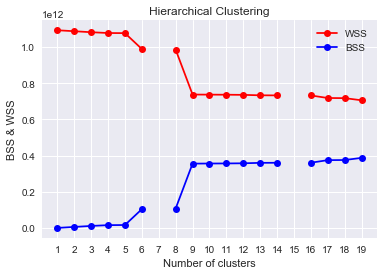

In [22]:
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

In [23]:
#yp = KMeans(n_clusters=10).fit_predict(x)

In [26]:
def KneeElbowAnalysis(x,max_k=10):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=12334).fit(x) for k in k_values]
    centroids_k = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids_k]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(k_values, wcss, 'bo-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'bo-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('Knee for KMeans clustering');



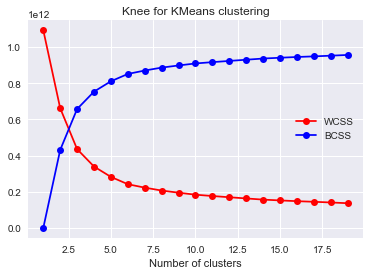

In [27]:
KneeElbowAnalysis(x,20)